In [13]:
import pandas as pd

In [14]:
import plotly.graph_objects as go

In [15]:
from statsmodels.tsa.stattools import adfuller, kpss


In [16]:
energy_data = pd.read_csv('Energy_consumption.csv')

In [17]:
energy_data.Timestamp = pd.to_datetime(energy_data.Timestamp)
energy_data = energy_data.set_index("Timestamp")

In [19]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = energy_data.index,
        y = energy_data.EnergyConsumption
    )
)

fig.update_layout(
    title = "Energy Consumption over Time",
    xaxis_title = "Time",
    yaxis_title = "Energy Consumption (kWh)",
    template = "plotly_dark"
)

In [20]:
energy_data.isna().sum()

Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64

## Stationary Testing

In [21]:
# --- ADF Test
def adf_test(x):
    res = adfuller(x, autolag="AIC")
    keys = ['test_stat', 'pvalue', 'lags', 'nobs', 'crit_values', 'icbest']
    return dict(zip(keys, [res[0], res[1], res[2], res[3], res[4], res[5]]))

In [28]:
# --- KPSS Test
def kpss_test(x, regression="c", nlags="auto"):
    stat, pval, lags, crit = kpss(x, regression=regression, nlags=nlags) #la diferencia con la anterior función, es cómo lo regresa
    keys = ['test_stat', 'pvalue', 'lags', 'crit_values']
    return {"test_stat": stat, 
            "pvalue": pval, 
            "lags": lags, 
            "crit_values": crit, 
            "regression": regression}

def print_test(x, name="Series"):
    print(f"Test {name}")
    a = adf_test(x)
    print(f"ADF Statistic: {a['test_stat']:.3f} p={a['pvalue']}")
    if a['pvalue'] < 0.05:
        print("ADF: Stationary (rejects H0)")
    else:
        print("ADF: Non-stationary (fails to reject H0)")

    try:
        k = kpss_test(x, regression="c")
        print(f"KPSS: stat={k['test_stst']:.3f} p={k['pvalue']}")
        if k['pvalue'] < 0.05:
            print("KPSS: Non-stationary (rejects H0)")
        else:
            print("KPSS: Stationary (fails to reject H0)")
    except: 
        print("KPSS test failed")

In [26]:
energy_data.head()



,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [29]:
print_test(energy_data["EnergyConsumption"], "Energy Consumption")

Test Energy Consumption
ADF Statistic: -31.577 p=0.0
ADF: Stationary (rejects H0)
KPSS test failed


/var/folders/0b/36rw0ltd0vg3t22nhv3dkq0r0000gn/T/ipykernel_77168/486501902.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




## Model Building and Evaluation

<Figure size 800x400 with 0 Axes>

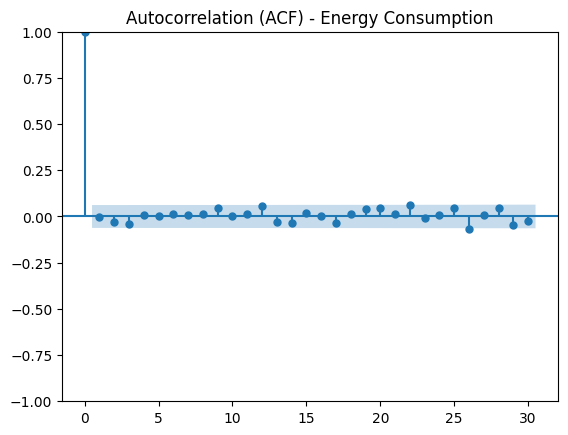

<Figure size 800x400 with 0 Axes>

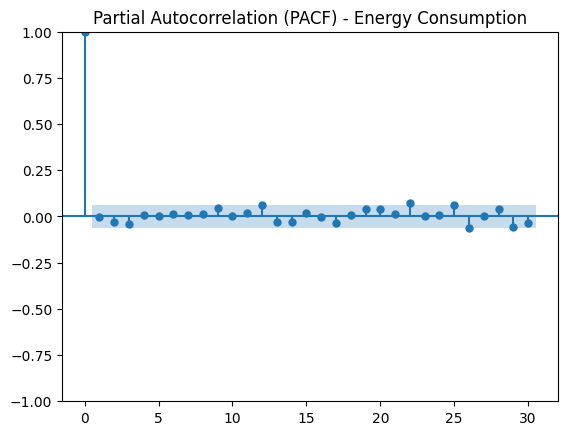

In [63]:
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Plot ACF and PACF ----

plt.figure(figsize=(8, 4))
plot_acf(energy_data["EnergyConsumption"], title="Autocorrelation (ACF) - Energy Consumption")
plt.show()


plt.figure(figsize=(8, 4))
plot_pacf(energy_data["EnergyConsumption"], title="Partial Autocorrelation (PACF) - Energy Consumption")
plt.show()


## ARIMA

In [80]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(energy_data["EnergyConsumption"],order=(21,7,21))
model_fit = model.fit()

#print the model summary
print(model_fit.summary())
predictions = model_fit.fittedvalues

# Compute RMSE
actual = energy_data["EnergyConsumption"].iloc[0:] 
rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f"\nRMSE (in-sample): {rmse:.3f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likel

                               SARIMAX Results                                
Dep. Variable:      EnergyConsumption   No. Observations:                 1000
Model:               ARIMA(21, 7, 21)   Log Likelihood               -3943.292
Date:                Wed, 05 Nov 2025   AIC                           7972.584
Time:                        18:31:48   BIC                           8183.315
Sample:                    01-01-2022   HQIC                          8052.704
                         - 02-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -6.6168      0.006  -1110.116      0.000      -6.628      -6.605
ar.L2        -24.5207      0.022  -1135.485      0.000     -24.563     -24.478
ar.L3        -65.6988      0.051  -1297.224      0.0

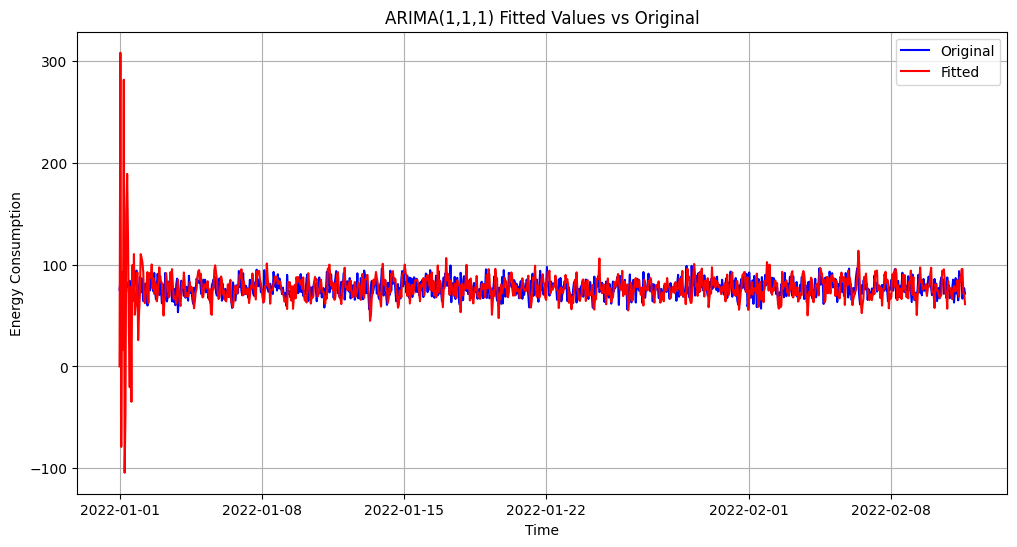

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(energy_data["EnergyConsumption"], label='Original', color='blue')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.title('ARIMA(1,1,1) Fitted Values vs Original')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
residuals = model_fit.resid

In [82]:
model_2 = ARIMA(energy_data["EnergyConsumption"], order=(2,1,2))
model_fit = model_2.fit()
#print the model summary
print(model_fit.summary())
predictions = model_fit.fittedvalues

# Compute RMSE
actual = energy_data["EnergyConsumption"].iloc[0:] 
rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f"\nRMSE (in-sample): {rmse:.3f}")

                               SARIMAX Results                                
Dep. Variable:      EnergyConsumption   No. Observations:                 1000
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3516.094
Date:                Wed, 05 Nov 2025   AIC                           7042.189
Time:                        18:32:08   BIC                           7066.723
Sample:                    01-01-2022   HQIC                          7051.514
                         - 02-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9475      0.255     -3.723      0.000      -1.446      -0.449
ar.L2          0.0046      0.033      0.139      0.889      -0.060       0.070
ma.L1         -0.0510      0.253     -0.201      0.8

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



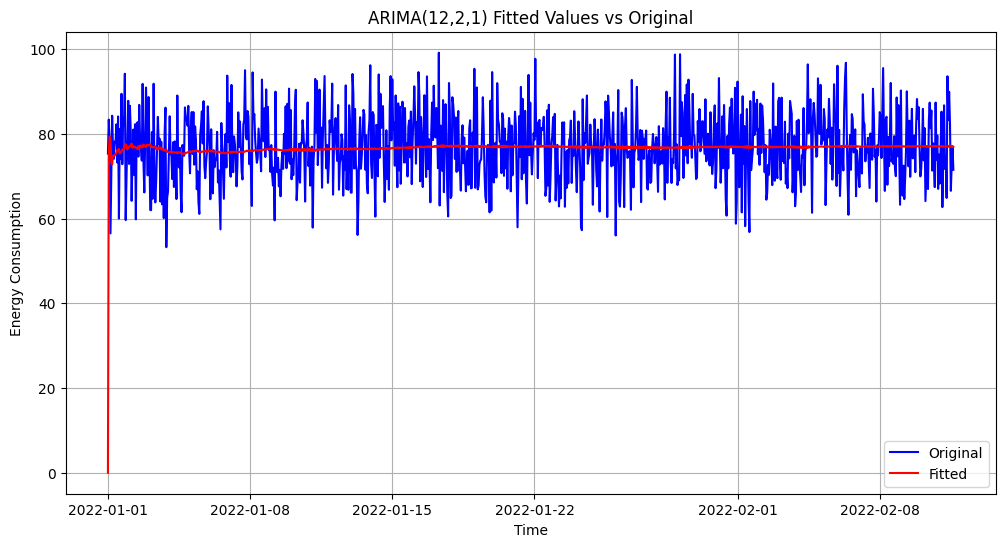

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(energy_data["EnergyConsumption"], label='Original', color='blue')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.title('ARIMA(12,2,1) Fitted Values vs Original')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.show()

## DIAGNOSTIC RESULTS FOR RESIDUALS

● Ljung-Box (L1) (Q): This tests for autocorrelation in the residuals. A p-value (Prob(Q))
greater than 0.05 suggests no significant autocorrelation.
● Jarque-Bera (JB): This tests for normality in the residuals. A p-value (Prob(JB)) greater than
0.05 indicates that residuals are normally distributed.
● Heteroskedasticity (H): This tests for constant variance (homoskedasticity) in the residuals.
A p-value (Prob(H)) less than 0.05 indicates heteroskedasticity.


## FORECASTING AND INTERPRETATION